Exploring how to calibrate frequency switched data.

In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from copy import copy
import numpy.lib.recfunctions as rfn

import pandas as pd

from astropy.io import fits
from astropy import units as u
from astropy import constants as ac

import dysh.util as util

In [3]:
def parse_query(query, op="and"):
    """ Takes a dictionary with keys as SDFITS columns
    and whose values are a tuple with the condition and 
    the required value and concatenates them using the
    `op` operator.
    """
    q = ""
    for i,(k,v) in enumerate(query.items()):
        q += f"{k} {v[0]} {v[1]} "
        if i < len(query) - 1:
            q += f"{op} "
    return q


def select_rows(df, query, op="and"):
    """ Returns a list with the rows of a `pandas.DataFrame`
    that fulfill the query.
    See `parse_query` for details on how to define the query.
    """

    q = parse_query(query, op=op)
    return np.array(list(df.query(q).index))


def channel_to_frequency(crval1, crpix1, cdelt1, vframe, nchan, nint, ndim=1):
    """
    """

    # Compute the correction factor.
    beta   = (vframe * u.m/u.s) /ac.c
    vcorr  = np.sqrt((1.0 + beta)/(1.0 - beta))

    # The +1 is to start counting from 1.
    indx = np.arange(nchan) + 1
    if ndim == 1:
        freq = (crval1 + cdelt1*(indx - crpix1))
        freq *= vcorr
    elif ndim == 2:
        indx = np.tile(indx, (nint,1))
        freq = (crval1[:,np.newaxis] + \
                cdelt1[:,np.newaxis]*(indx - crpix1[:,np.newaxis]))
        freq *= vcorr[:,np.newaxis]

    return freq
    

def index_frequency(df):
    """
    Create a frequency axis from an index.
    This assumes all entries in the index have the same number of channels.
    """
    
    ndim = len(df.shape)
    nint = df.shape[0]

    if ndim == 1:
        nchan = np.array([int(df["TDIM7"][1:-1].split(",")[0])])
    else:
        nchan = np.array([int(df["TDIM7"].iloc[i][1:-1].split(",")[0]) for i in range(len(df))])

    crval1 = df["CRVAL1"]
    crpix1 = df["CRPIX1"]
    cdelt1 = df["CDELT1"]
    vframe = df['VFRAME'] # Use the velocity frame requested by the user.
    
    if ndim == 2:
        crval1 = crval1.to_numpy()
        crpix1 = crpix1.to_numpy()
        cdelt1 = cdelt1.to_numpy()
        vframe = vframe.to_numpy()

    freq = channel_to_frequency(crval1, crpix1, cdelt1, vframe, nchan[0], nint, ndim=ndim)
    
    # Apply units.
    try:
        cunit1 = u.Unit(df["CUNIT1"])
        if ndim == 2:
            cunit1 = cunit[0]
    except KeyError:
        cunit1 = u.Hz

    return freq * cunit1


def table_frequency(table):
    """
    """

    ndim = len(table["DATA"].shape)
    nint = table["DATA"].shape[0]

    if ndim == 1:
        nchan = np.array([int(table["TDIM7"][1:-1].split(",")[0])])
    else:
        nchan = np.array([int(table["TDIM7"][i][1:-1].split(",")[0]) for i in range(nint)])

    crval1 = table["CRVAL1"]
    crpix1 = table["CRPIX1"]
    cdelt1 = table["CDELT1"]
    vframe = table['VFRAME'] # Use the velocity frame requested by the user.
    
    freq = channel_to_frequency(crval1, crpix1, cdelt1, vframe, nchan[0], nint, ndim=ndim)
    
    # Apply units.
    try:
        cunit1 = u.Unit(table["CUNIT1"])
        if ndim == 2:
            cunit1 = cunit[0]
    except KeyError:
        cunit1 = u.Hz

    return freq * cunit1


def get_nchan(table):
    """
    """

    ndim = len(table["DATA"].shape)

    if ndim == 1:
        nchan = np.array([int(table["TDIM7"][1:-1].split(",")[0])])
    else:
        nchan = np.array([int(table["TDIM7"][i][1:-1].split(",")[0]) for i in range(len(table))])

    return nchan


def do_total_power(no_cal, cal, tcal):#, tsys_med=False):
    """
    """

    tsys = vec_mean_tsys(cal["DATA"], no_cal["DATA"], tcal)
    tp_data = 0.5*(cal["DATA"] + no_cal["DATA"])

    tp = copy(cal)
    tp["DATA"] = tp_data
    tp["EXPOSURE"] = cal["EXPOSURE"] + no_cal["EXPOSURE"]
    # If we want to store a vector for TSYS, then we need
    # to reshape the SDFITS.
    # if not tsys_med:
    #     nchan = get_nchan(tp)
    #     tp = reshape_column(tp, "TSYS", ">f4", (nchan[0],))
    #     tp["TSYS"] = tsys
    # else:
    #     tp["TSYS"] = np.nanmedian(tsys, axis=1)
    tp["TSYS"] = tsys

    return tp


def vec_mean_tsys(on, off, tcal):
    """
    Compute the system temperature given integrations 
    with the noise diode on and off and the temperature
    of the noise diode.

    Rewriten to work with arrays, but not well enough that 
    this would work with one dimensional data.
    """

    assert on.shape == off.shape
    
    # Make them doubles. Probably not worth it.
    caloff = off.astype("d")
    calon = on.astype("d")

    nchan = on.shape[1]
    chrng = slice(nchan//10, 1-nchan//10, 1)

    # Compute the system temperature.
    # Removed the tcal/2 factor that does not make sense.
    tsys = np.nanmean(caloff[:,chrng], axis=1) / np.nanmean((calon - caloff)[:,chrng], axis=1) * tcal    

    return tsys


def reshape_column(table, column, new_dtype, new_shape):
    """
    Reshape an SDFITS table `column` to have the `new_dtype`
    and `new_shape`. This might not work with the 'DATA'
    column.
    """

    column_loc = {"DATA": 6,
                  "TSYS": 5,
                 }

    ntime = len(table)
    nocol_table = rfn.drop_fields(table.copy(), column)
    nocol_table_dt = nocol_table.dtype.descr
    col_dt = [(column, new_dtype, new_shape)]
    new_dt = np.dtype(nocol_table_dt[:column_loc[column]] + \
                      col_dt + nocol_table_dt[column_loc[column]:])
    new_table = np.empty(ntime, dtype=new_dt)

    for n in nocol_table.dtype.names:
        new_table[n] = nocol_table[n]

    return new_table


def do_sig_ref(sig, ref, smooth=False):
    """
    Calibrate using signal and reference spectra.
    """

    # Here we would smooth the reference or something.
    if smooth:
        #
        pass
    nsmooth = 1.

    result = (sig["DATA"] - ref["DATA"])/ref["DATA"] * ref["TSYS"][:,np.newaxis]

    out = copy(sig)
    out["DATA"] = result
    out["EXPOSURE"] = sig["EXPOSURE"]*ref["EXPOSURE"]*nsmooth/(sig["EXPOSURE"] + ref["EXPOSURE"]*nsmooth)
    out["TSYS"] = ref["TSYS"]

    return out


def do_fold(sig, ref, sig_freq, ref_freq, remove_wrap=False):
    """
    Fold together the signal and reference spectra.
    """

    chan_shift = (sig_freq[0,0] - ref_freq[0,0])/np.abs(np.diff(sig_freq)).mean()
    ref_shift = do_shift(ref, chan_shift, remove_wrap=remove_wrap)

    # sig_w = sig["EXPOSURE"][:,np.newaxis]*abs(sig["CDELT1"][:,np.newaxis])/np.power(sig["TSYS"], 2.)
    # ref_w = ref["EXPOSURE"][:,np.newaxis]*abs(ref["CDELT1"][:,np.newaxis])/np.power(ref["TSYS"], 2.)
    sig_w = (sig["EXPOSURE"]*abs(sig["CDELT1"])/np.power(sig["TSYS"], 2.))[:,np.newaxis]
    ref_w = (ref["EXPOSURE"]*abs(ref["CDELT1"])/np.power(ref["TSYS"], 2.))[:,np.newaxis]
    
    avg = (sig["DATA"]*sig_w + ref_shift["DATA"]*ref_w) / (sig_w + ref_w)

    out = copy(sig)
    out["DATA"] = avg
    # This needs to be implemented.
    # out["TSYS"] = 
    out["EXPOSURE"] = sig["EXPOSURE"] + ref["EXPOSURE"]

    return out


def do_shift(table, offset, remove_wrap=False):
    """
    Shift the data of an SDFITS.
    """

    out_table = table.copy()
    
    ishift = int(np.round(offset)) # Integer shift.
    fshift = offset - ishift # Fractional shift.

    dshape = out_table["DATA"].shape
    
    # Shift the data by `ishift` channels.
    if len(dshape) == 2:
        data = np.roll(out_table["DATA"], ishift, axis=1)
        if remove_wrap:
            if ishift < 0:
                data[:,ishift:] = np.nan
            else:
                data[:,:ishift] = np.nan
    elif len(dshape) == 1:
        data = np.roll(out_table["DATA"], ishift, axis=0)
        if remove_wrap:
            if ishift < 0:
                data[ishift:] = np.nan
            else:
                data[:ishift] = np.nan
    out_table["DATA"] = data

    # Then we should handle wrapping and fractional shifts.
    #
    #
    fshift = 0.0

    out_table["CRPIX1"] -= ishift + fshift
    
    return out_table

In [4]:
testdata  = util.get_project_testdata()
data_path = testdata  / "TGBT21A_504_01/TGBT21A_504_01.raw.vegas/TGBT21A_504_01.raw.vegas.A.fits"

scan  = 20
ifnum = 0
fdnum = 0
plnum = 0
fold  = True

In [5]:
# Load the data.
hdu = fits.open(data_path)
table = hdu[1].data

In [6]:
# Create an index.
df = pd.DataFrame(rfn.drop_fields(table, "DATA"))
# Select columns that are strings, decode them and remove white spaces.
df_obj = df.select_dtypes(["object"])
df[df_obj.columns] = df_obj.apply(lambda x: x.str.decode("utf-8").str.strip())

In [7]:
# Get the indices of the different switching states.
q = {"SCAN": ("in", f"[{scan}]"), 
     "IFNUM": ("in", f"[{ifnum}]"), 
     "FDNUM": ("in", f"[{fdnum}]"), 
     "PLNUM": ("==", plnum), 
     "CAL": ("==", "'T'"),
     "SIG": ("==", "'T'"),
}
sig_cal = select_rows(df, q, op="and")
q.update({"CAL": ("==", "'F'")})
sig = select_rows(df, q, op="and")
q.update({"SIG": ("==", "'F'")})
ref = select_rows(df, q, op="and")
q.update({"CAL": ("==", "'T'")})
ref_cal = select_rows(df, q, op="and")

In [8]:
sig, ref, sig_cal, ref_cal

(array([ 4, 12, 20, 28, 36, 44, 52, 60, 68, 76, 84]),
 array([ 6, 14, 22, 30, 38, 46, 54, 62, 70, 78, 86]),
 array([ 5, 13, 21, 29, 37, 45, 53, 61, 69, 77, 85]),
 array([ 7, 15, 23, 31, 39, 47, 55, 63, 71, 79, 87]))

In [9]:
# Determine if this is in-band or out-of-band frequency switching.
nchan = table["DATA"].shape[1]
sig_freq = index_frequency(df.iloc[sig])
ref_freq = index_frequency(df.iloc[ref])
chan_shift = abs(sig_freq[0,0] - ref_freq[0,0])/np.abs(np.diff(sig_freq)).mean()
print(chan_shift)
if nchan > chan_shift:
    in_band = True
else:
    in_band = False

6990.506666261921


In [10]:
# Fix TCAL to make everything consistent.
tcal = table[sig]["TCAL"][0]
tp_sig = do_total_power(table[sig], table[sig_cal], tcal)#, tsys_med=False)
tp_ref = do_total_power(table[ref], table[ref_cal], tcal)#, tsys_med=False)

/tmp/ipykernel_14691/4284855667.py:173: RuntimeWarning: Mean of empty slice
  tsys = np.nanmean(caloff[:,chrng], axis=1) / np.nanmean((calon - caloff)[:,chrng], axis=1) * tcal


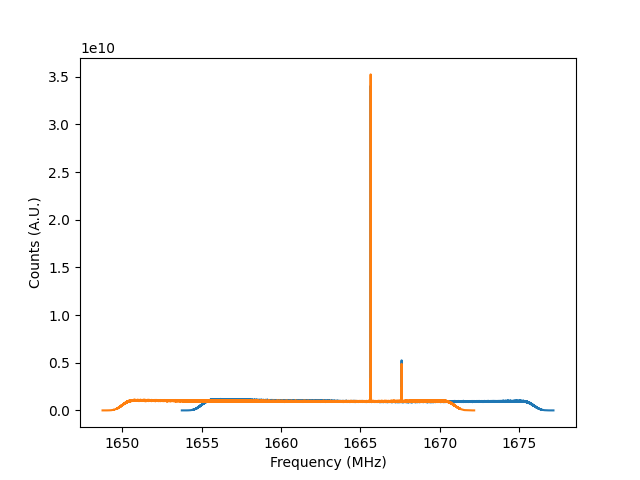

In [11]:
plt.figure()
plt.plot(sig_freq[0].to("MHz").value, tp_sig["DATA"][0])
plt.plot(ref_freq[0].to("MHz").value, tp_ref["DATA"][0])
plt.xlabel("Frequency (MHz)")
plt.ylabel("Counts (A.U.)");

In [12]:
# Calibrate the data.
cal_sig = do_sig_ref(tp_sig, tp_ref, smooth=False)
cal_ref = do_sig_ref(tp_ref, tp_sig, smooth=False)

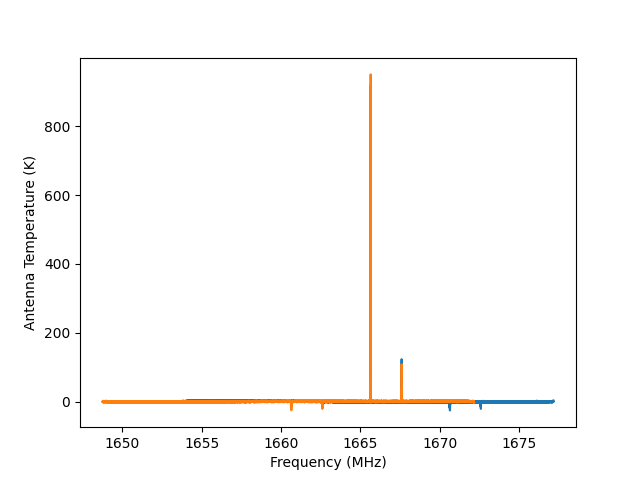

In [13]:
plt.figure()
plt.plot(sig_freq[0].to("MHz").value, cal_sig["DATA"][0])
plt.plot(ref_freq[0].to("MHz").value, cal_ref["DATA"][0])
plt.xlabel("Frequency (MHz)")
plt.ylabel("Antenna Temperature (K)");

In [14]:
# Shift the reference for folding.
# This should only take place when 
# this is in-band frequency switching.
if in_band and fold:
    cal_sig_fold = do_fold(cal_sig, cal_ref, sig_freq, ref_freq)
    cal_ref_fold = do_fold(cal_ref, cal_sig, ref_freq, sig_freq)

In [15]:
cal_sig_freq = table_frequency(cal_sig_fold)
cal_ref_freq = table_frequency(cal_ref_fold)

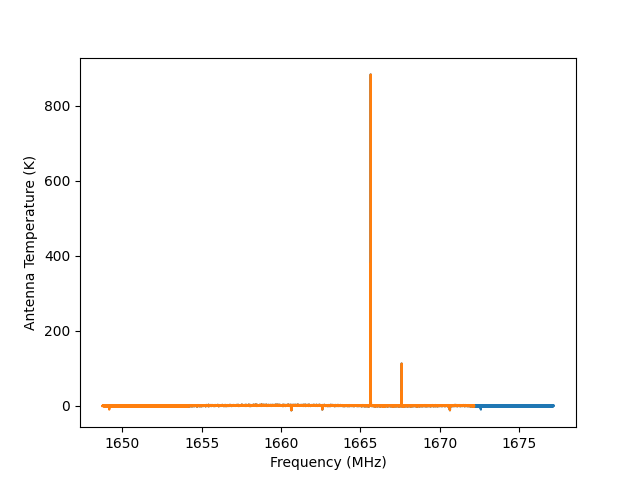

In [16]:
plt.figure()
plt.plot(cal_sig_freq[0].to("MHz").value, cal_sig_fold["DATA"][0], drawstyle='steps-mid')
plt.plot(cal_ref_freq[0].to("MHz").value, cal_ref_fold["DATA"][0], drawstyle='steps-mid')
plt.xlabel("Frequency (MHz)")
plt.ylabel("Antenna Temperature (K)");

Notice that there's still half a channel shift between spectra. This is also likely why the results does not match the one from GBTIDL.

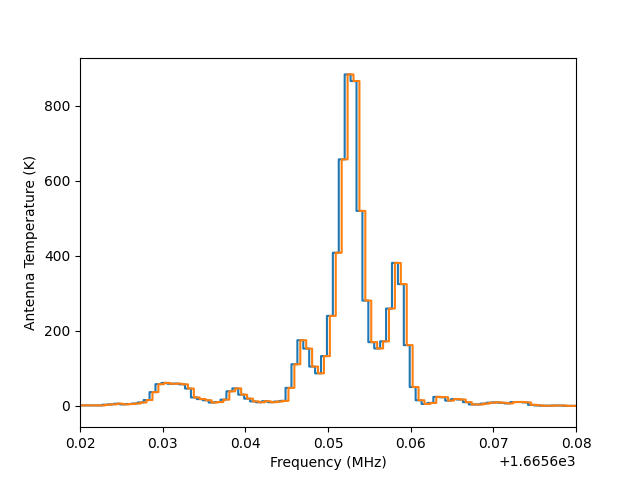

In [17]:
plt.figure()
plt.plot(cal_sig_freq[0].to("MHz").value, cal_sig_fold["DATA"][0], drawstyle='steps-mid')
plt.plot(cal_ref_freq[0].to("MHz").value, cal_ref_fold["DATA"][0], drawstyle='steps-mid')
plt.xlim(1665.62, 1665.68)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Antenna Temperature (K)");